In [3]:
import codecs
import numpy as np
import gensim
import io
import sys
import codecs
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, LSTM, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder

C:\Users\Sizov\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Data preprocessing

In [4]:
text_name = "data_for_lab5/potter_no_signs.txt"
with codecs.open(text_name, encoding= 'utf-8', mode='r') as f:
    docs = f.readlines()#.replace("\r\n", " ")

In [5]:
print (type(docs))

<class 'list'>


In [6]:
max_sentence_len = 20
sentences = [sent for doc in docs for sent in doc.split('.')]
sentences = [[word for word in sent.lower().split()[:max_sentence_len]] for sent in sentences]
print(len(sentences), 'предложений')

28242 предложений


# Model training

In [7]:
word_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, epochs=200)
word_model.save("word2vec.model")

In [8]:
print('Похожие слова:')
for word in ['гермиона', 'гарри', 'палочка', 'собака', 'зелье','турнир','кубок']:
    most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
    print('  %s -> %s' % (word, most_similar))

Похожие слова:
  гермиона -> она (0.60), полумна (0.52), анджелина (0.47), чжоу (0.43), амбридж (0.42), лили (0.37), рита (0.37), впечатляюще (0.36)
  гарри -> он (0.87), и (0.73), не (0.67), на (0.66), в (0.63), что (0.62), с (0.57), я (0.57)
  палочка -> волшебная (0.65), перекрещенные (0.62), красовались (0.60), кость (0.58), правой (0.53), бута (0.50), направленная (0.49), подбородок (0.49)
  собака -> укусит (0.72), ровен (0.68), залаяла (0.62), исступленно (0.54), получают (0.54), милости (0.52), мулы (0.51), упрямые (0.51)
  зелье -> максимальное (0.54), свертывалось (0.54), оборотном (0.53), строение (0.52), кропотливой (0.51), сложнее (0.50), входит (0.49), крововосполняющее (0.47)
  турнир -> родословная (0.72), раскошеливайтесь (0.67), лаются (0.65), полезные (0.64), арагога (0.64), считало (0.63), юных (0.63), чрезвычайной (0.62)
  кубок -> удалось-таки (0.48), выиграть (0.48), разыгрывался (0.47), оставляет (0.47), шумок (0.47), пуффендуйцам (0.47), привыкла (0.45), опушки

In [9]:
matrix =np.array(word_model.wv.get_vector('палочка'))

In [10]:
vec = word_model.wv.get_vector('слизерин') + word_model.wv.get_vector('малфой') 
word_model.wv.similar_by_vector(vec)

[('малфой', 0.9592278599739075),
 ('пса', 0.4910598695278168),
 ('обормоттер', 0.43249014019966125),
 ('оборзел', 0.42930540442466736),
 ('де-мен-то-ра', 0.39481279253959656),
 ('у-тю-тю', 0.3914267122745514),
 ('снегг', 0.38744285702705383),
 ('замочными', 0.3759876787662506),
 ('наступать', 0.37514328956604004),
 ('изловить', 0.3735141158103943)]

In [11]:
df = pd.read_csv('./data_for_lab5/production.csv')
df.head()

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,5005072170100,2014,11,9783,11470,1.172442,10558,1.079219,14,2016-04-06 17:20:05.757
1,5005072170100,2014,12,24206,26476,1.093778,5719,0.236264,31,2016-04-06 17:20:05.757
2,5005072170100,2015,1,20449,26381,1.290088,2196,0.107389,31,2016-04-06 17:20:05.757
3,5005072170100,2015,2,6820,10390,1.523460,583,0.085484,28,2016-04-06 17:20:05.757
4,5005072170100,2015,3,7349,7005,0.953191,122,0.016601,13,2016-06-16 14:07:33.203


In [12]:
input_params = df.groupby('API')[['Liquid', 'Gas', 'Water']].apply(lambda df_: df_.reset_index(drop=True))
input_params.head()

Liquid    Gas  Water
API                                  
5005072170100 0    9783  11470  10558
              1   24206  26476   5719
              2   20449  26381   2196
              3    6820  10390    583
              4    7349   7005    122

In [13]:
df_prod = input_params.unstack()
df_prod.head()

Liquid                                                       \
                  0      1      2     3     4      5      6      7     8    
API                                                                         
5005072170100   9783  24206  20449  6820  7349  16552  13844  10655  6135   
5123377130000   2341   4689   3056  1979  2037   2260   1961   1549  1364   
5123379280000   6326   6405   6839  6584  4775   3917   3840   3031  3137   
5123379400000   8644  13977   9325  6445  5326   4538   3403   2534  2685   
5123385820100   1753   4402   1187  1204  1176   1523   1169    782   634   

                      ... Water                                               
                  9   ...    14   15   16   17   18   19   20   21   22   23  
API                   ...                                                     
5005072170100  11105  ...   357  270  242  236  250  200  241  215  194  188  
5123377130000   1380  ...   193  118  111  111   91  100  137  109  113   55  
5123379280000   2669  ...   218  256  203  207  225  180  194  202  182  208  
5123379400000   2597  ...   197  156  193  226  135  190  162  181  189   34  
5123385820100    597  ...   124    0    0    0    0    0  119  568  521  289  

[5 rows x 72 columns]

In [14]:
data = df_prod.values
data = data / data.max()
data = data[:, :, np.newaxis]

data_tr = data[:40]
data_tst = data[40:]
data_tr = data_tr.reshape(40, 24, 3)
data_tst = data_tst.reshape(10, 24, 3)

print(data_tr.shape, data_tst.shape)

(40, 24, 3) (10, 24, 3)


In [15]:
x_data = [data_tr[:, i:i+12] for i in range(11)]
y_data = [data_tr[:, i+1:i+13] for i in range(11)]

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)

(440, 12, 3) (440, 12, 3)


In [16]:
timesteps = 12
inp = Input(shape=(timesteps, 3))
lstm = LSTM(units=32, return_sequences=True)(inp)
lstm = LSTM(units=32, return_sequences=True)(lstm)
out = Dense(3, activation="relu")(lstm)

model = Model(inp, out)
model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 12, 32)            4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 32)            8320      
_________________________________________________________________
dense (Dense)                (None, 12, 3)             99        
Total params: 13,027
Trainable params: 13,027
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(x_data, y_data, epochs=20)

Epoch 1/20
14/14 [==============================] - 0s 26ms/step - loss: 0.0053 - mae: 0.0447
Epoch 2/20
14/14 [==============================] - 0s 23ms/step - loss: 0.0046 - mae: 0.0425
Epoch 3/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0039 - mae: 0.0390
Epoch 4/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0035 - mae: 0.0388
Epoch 5/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0032 - mae: 0.0353
Epoch 6/20
14/14 [==============================] - 0s 22ms/step - loss: 0.0029 - mae: 0.0343
Epoch 7/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0027 - mae: 0.0325
Epoch 8/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0027 - mae: 0.0318
Epoch 9/20
14/14 [==============================] - 0s 21ms/step - loss: 0.0026 - mae: 0.0310
Epoch 10/20
14/14 [==============================] - 0s 19ms/step - loss: 0.0025 - mae: 0.0306
Epoch 11/20
14/14 [==============================] - 0s 10m

In [18]:
x_tst = data_tst[:, :12]
predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))
print(predicts.shape)
for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    pred = model.predict(x)
    last_pred = pred[:, -1:]  # Нас интересует только последний месяц
    predicts = np.concatenate((predicts, last_pred), axis=1)

(10, 0, 3)


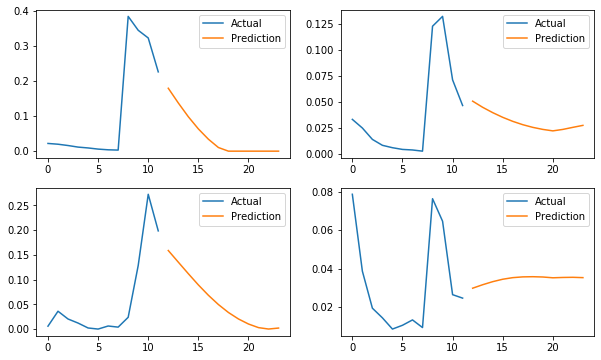

In [19]:
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(np.arange(x_tst.shape[1]), x_tst[i, :, 0], label='Actual')
    plt.plot(np.arange(predicts.shape[1])+x_tst.shape[1], predicts[i, :, 0], label='Prediction')
    plt.legend()
plt.show()

In [20]:
text_name = "data_for_lab5/potter_short.txt"
with codecs.open(text_name, encoding= 'utf-8', mode='r') as f:
    short_text = f.read(2000)
short_text = short_text.lower()
print(short_text)
print(len(short_text))

джоан роулинг    гарри поттер и орден феникса       глава 1. дадли досталось     самый пока что жаркий день знойного лета клонился к вечеру  и большие прямоугольные дома тисовой улицы окутывала сонная тишина. машины  обычно сверкавшие чистотой  стояли пыльные  а лужайки были уже не изумрудно зелеными  а иссохшими  желтоватыми из за нехватки воды жителям запретили пользоваться шлангами. лишенные таких важных занятий  как мытье машин и стрижка газонов  обитатели тисовой сидели по комнатам  где было чуть прохладней  широко распахнув окна в несбыточной надежде на освежающее дуновение. единственным  кто не находился дома  был подросток  лежавший лицом вверх на цветочной клумбе у дома номер четыре.    это был худой  черноволосый парнишка в очках  чуть болезненный и угловатый на вид    посмотришь  и сразу ясно  что он сильно вытянулся за короткое время. джинсы рваные и грязные  футболка мешковатая и выцветшая  кроссовки скоро запросят каши. одним словом  наружность гарри поттера не красила ег

In [40]:
chars = sorted(list(set(short_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

char_to_index = {v:i for i,v in enumerate(chars)}
index_to_char = {i:v for i,v in enumerate(chars)}
n_chars = len(short_text)
encoding_size = len(chars)

print("Total characters:", n_chars)
print("Encoding size:", encoding_size)

print(int_to_char)

Total characters: 2000
Encoding size: 34
{0: ' ', 1: '.', 2: '1', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'и', 12: 'й', 13: 'к', 14: 'л', 15: 'м', 16: 'н', 17: 'о', 18: 'п', 19: 'р', 20: 'с', 21: 'т', 22: 'у', 23: 'ф', 24: 'х', 25: 'ц', 26: 'ч', 27: 'ш', 28: 'щ', 29: 'ы', 30: 'ь', 31: 'э', 32: 'ю', 33: 'я'}


In [22]:
sentence_len = 50
sentences_x = [short_text[i:i+sentence_len] for i in range(0,len(short_text), sentence_len)]
sentences_y = [short_text[i] for i in range(0,len(short_text), sentence_len)]
n_sentences = len(sentences_x)
print(n_sentences)
print(len(sentences_y))

40
40


In [23]:
print(len(short_text))
integer_encoded = [char_to_int[char] for char in short_text]
sentences_y = [char_to_int[char] for char in sentences_y]
for i in range(n_sentences):
    for j in range(sentence_len):
        onehot_encoded= list()
        for value in integer_encoded:
            letter = [0 for i in range(encoding_size)]
            letter[value] = 1
            onehot_encoded.append(letter)
print(np.shape(onehot_encoded))
print(onehot_encoded)


2000
(2000, 34)
[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0

In [91]:
X = np.reshape(onehot_encoded, (n_sentences, sentence_len, encoding_size))
print(X.shape)
y = np_utils.to_categorical(sentences_y)
print (y.shape)

(40, 50, 34)
(40, 34)


# Define RNN

In [92]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model_rnn = Sequential()
model_rnn.add(LSTM(256, activation='softmax', input_shape=(X.shape[1], X.shape[2])))
model_rnn.add(Dense(y.shape[1],activation="softmax"))
model_rnn.add(Dropout(0.2))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy')
model_rnn.summary()
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam')
model_rnn.fit(X, y, epochs=25, batch_size=128)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 256)               297984    
_________________________________________________________________
dense_5 (Dense)              (None, 34)                8738      
_________________________________________________________________
dropout_2 (Dropout)          (None, 34)                0         
Total params: 306,722
Trainable params: 306,722
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1/1 [==============================] - 0s 2ms/step - loss: 6.1850
Epoch 2/25
1/1 [==============================] - 0s 3ms/step - loss: 4.9112
Epoch 3/25
1/1 [==============================] - 0s 2ms/step - loss: 5.5218
Epoch 4/25
1/1 [==============================] - 0s 2ms/step - loss: 5.5599
Epoch 5/25
1/1 [==============================] - 0s 4ms/step - loss: 

In [93]:
model_rnn.save_weights('simpleRNN_3pred.h5')

In [96]:
model_rnn.predict(X[0])

ValueError: in user code:

    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 34]


In [109]:
def predict_next_char(inp):
    print(inp)
    index = [char_to_index[i] for i in inp]
    print(index)
    #arr = np.expand_dims(np.array(index), axis=(0,1))
    #arr = np.concatenate(index, )
    #print(arr.shape)
    prediction = model_rnn.predict(np.array(index))
    return arr
    #return index_to_char[np.argmax(prediction)]

In [100]:
start_pos = np.random.randint(0, len(sentences_x)-10)
#predict_next_char(sentences_x[start_pos: start_pos +10 ])
predict_next_char("гарри потте")

гарри потте
[6, 3, 19, 19, 11, 0, 18, 17, 21, 21, 8]


ValueError: in user code:

    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 1]


In [67]:
x_tst = sentences_x[12]
#predicts = np.zeros((x_tst.shape[0], 0, x_tst.shape[2]))
for i in range(12):
    x = np.concatenate((x_tst[:, i:], predicts), axis=1)
    pred = model_rnn.predict(x)
    last_pred = pred[:, -1:]
    predicts = np.concatenate((predicts, last_pred), axis=1)

TypeError: string indices must be integers

In [113]:
x_tst = (sentences_x[12])
predicts = np.zeros((0,len(x_tst), 0))
print(predicts.shape)

x = np.concatenate((x_tst, predicts), axis=0)
pred = model.predict(x)
last_pred = pred[:, -1:]  # Нас интересует только последний месяц
predicts = np.concatenate((predicts, last_pred), axis=1)

(0, 50, 0)


ValueError: zero-dimensional arrays cannot be concatenated